# Identification of low quality cells

In [12]:
from pathlib import Path
import seaborn as sns
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt

## QC: Read depth

In [13]:
# read flagstat data into a dataframe
DATADIR = "/iblm/logglun02/mcuoco/workflows/sz_slavseq/results/qc/flagstat"

data = {
    "donor_id": [],
    "cell_id": [],
    "n_reads": [],
}

files = list(Path(DATADIR).rglob("*tagged.sorted.flagstat"))
for f in tqdm(files, desc="Reading flagstat files"):
    # skip bulk samples
    if "gDNA" in f.name:
        continue
    data["donor_id"].append(f.parent.name)
    data["cell_id"].append(f.name.replace(".tagged.sorted.flagstat", ""))
    lines = f.read_text().splitlines()
    data["n_reads"].append(int(lines[0].split()[0]))

data = pd.DataFrame(data).set_index("cell_id")

Reading flagstat files:   0%|          | 0/4436 [00:00<?, ?it/s]

Reading flagstat files: 100%|██████████| 4436/4436 [00:06<00:00, 717.03it/s]


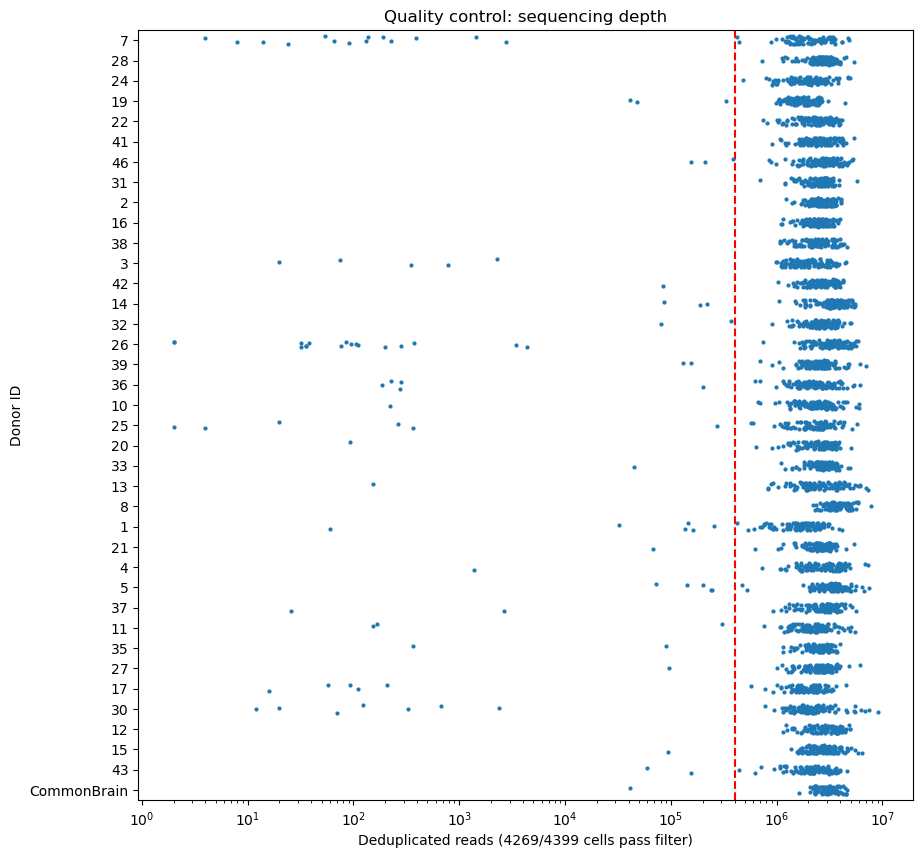

In [14]:
cutoff = 4e5
# mark cells with less than 10k reads as failing QC
data["depth_qc"] = data["n_reads"] > cutoff

# set seatborn width
g = sns.stripplot(data, y="donor_id", x="n_reads", jitter=0.2, size=3)
g.set_xscale("log")
g.set_title("Quality control: sequencing depth")
g.set_xlabel(
    "Deduplicated reads" + f" ({sum(data['depth_qc'])}/{len(data)} cells pass filter)"
)
g.set_ylabel("Donor ID")

# figure size
g.figure.set_size_inches(10, 10)

# add line
g.axvline(cutoff, color="red", linestyle="--")

## QC: Evenness of coverage

In [15]:
# takes ~5 min
DATADIR = "/iblm/logglun02/mcuoco/workflows/sz_slavseq/results/qc/l1_coverage"

files = list(Path(DATADIR).rglob("*rmsk_1kb_3end.r1.txt"))
for f in tqdm(files, desc="Reading l1_coverage files"):
    # skip bulk samples
    if "gDNA" in f.name:
        continue
    cell_id = f.name.replace(".rmsk_1kb_3end.r1.txt", "")
    if cell_id not in data.index:
        print(f"Skipping {cell_id}")

    df = pd.read_csv(
        f,
        sep="\t",
        usecols=[0, 1, 2, 3, 9],
        names=["Chromosome", "Start", "End", "Name", "Coverage"],
    )

    for l1 in ["L1HS", "L1PA2"]:
        data.loc[cell_id, f"{l1}_var"] = df[df["Name"] == l1]["Coverage"].std()
        data.loc[cell_id, f"{l1}_mean"] = df[df["Name"] == l1]["Coverage"].mean()
        data.loc[cell_id, f"{l1}_zeros"] = (df[df["Name"] == l1]["Coverage"] == 0).sum()

Reading l1_coverage files: 100%|██████████| 4436/4436 [03:45<00:00, 19.66it/s]


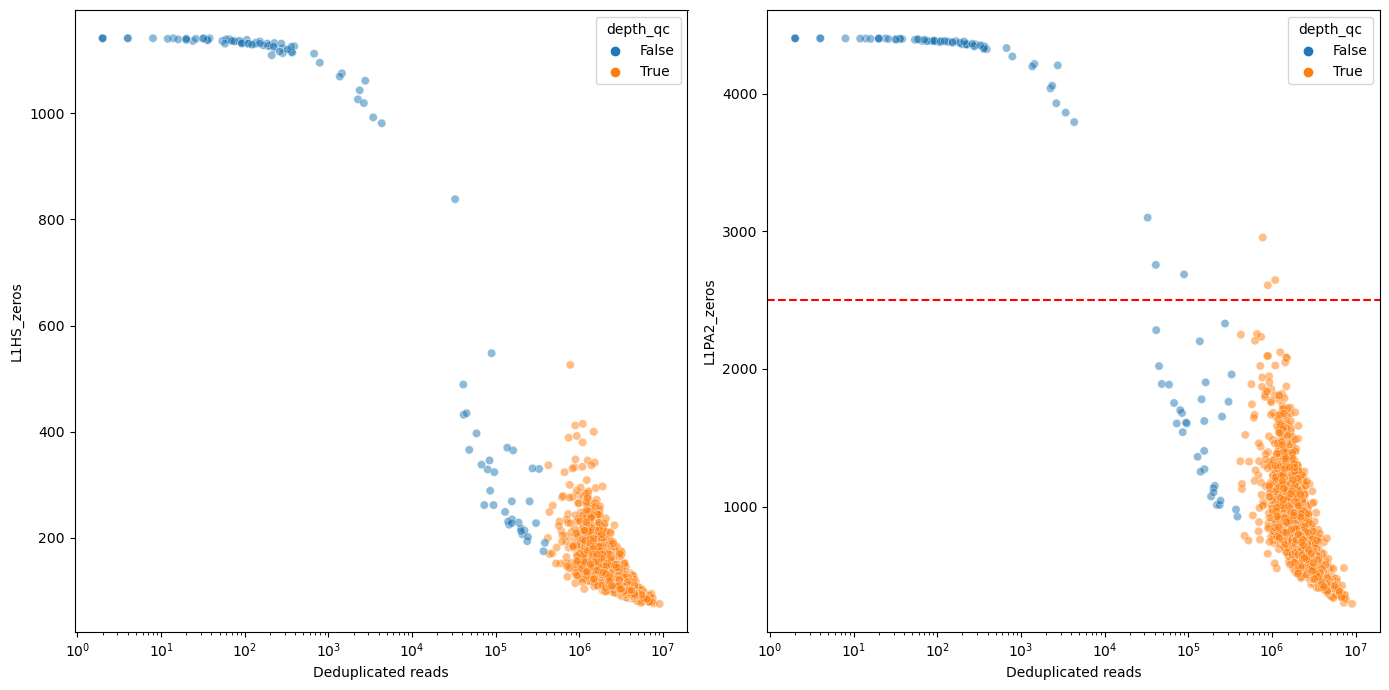

In [16]:
# mark cells with less than 10k reads as failing QC
data["coverage_qc"] = data["L1PA2_zeros"] < 2500

# make subplots
fig, axes = plt.subplots(1, 2, tight_layout=True, figsize=(14, 7))

f1 = sns.scatterplot(
    data, x="n_reads", y="L1HS_zeros", hue="depth_qc", alpha=0.5, ax=axes[0]
)
f1.set_xscale("log")
f1.set_xlabel("Deduplicated reads")


f2 = sns.scatterplot(
    data, x="n_reads", y="L1PA2_zeros", hue="depth_qc", alpha=0.5, ax=axes[1]
)
f2.set_xscale("log")
f2.set_xlabel("Deduplicated reads")
f2.axhline(2500, color="red", linestyle="--")

In [21]:
# write bad cells to file
data[(data["n_reads"] < 4e5) & (data["L1PA2_zeros"] > 2500)].index.to_series().to_csv(
    "../resources/bad_cells.txt", index=False, header=False
)